In [1]:
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

dill 0.3.8 is installed but dill<0.3.2,>=0.3.1.1 is required
Redoing requirement with just package name...
cloudpickle 3.0.0 is installed but cloudpickle~=2.2.1 is required
Redoing requirement with just package name...
numpy 1.26.4 is installed but numpy<1.25.0,>=1.14.3 is required
Redoing requirement with just package name...
pyarrow 16.1.0 is installed but pyarrow<10.0.0,>=3.0.0 is required
Redoing requirement with just package name...
jupyterlab 4.2.5 is installed but jupyterlab~=3.6.0 is required
Redoing requirement with just package name...
google-cloud-bigquery 2.34.4 is installed but google-cloud-bigquery[bqstorage,pandas]>=3.10.0 is required
Redoing requirement with just package name...
google-cloud-storage 1.44.0 is installed but google-cloud-storage>=2.0.0 is required
Redoing requirement with just package name...
pandas 2.2.2 is installed but pandas<2.1.4,>=1.5.0 is required
Redoing requirement with just package name...
botocore 1.35.23 is installed but botocore<1.30.0,>=1.29

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
import pandas as pd
from unsloth.chat_templates import get_chat_template, standardize_sharegpt
from datasets import load_dataset
from datasets import Dataset
# Load your dataset from the CSV file
df = pd.read_csv("/kaggle/input/iiitn-disha/iiitn.csv")

# Transform each row into a conversation format
df['conversations'] = df.apply(lambda row: [
    {"from": "human", "value": row['Name']},
    {"from": "gpt", "value": row['Details']}
], axis=1)

# Select only the `conversations` column
df = df[['conversations']]

# Convert the modified DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Verify the structure of the dataset
print(dataset[0])  # Print the first item to see the format

{'conversations': [{'from': 'human', 'value': 'cse_Dr_Prerna_Mishra'}, {'from': 'gpt', 'value': '{\n"name": "Dr Prerna Mishra",\n"department": "Computer Science and Engineering",\n"position": "Adjunct Assistant Professor",\n"phone_no": "9834485669",\n"email": "pmishra@iiitn.ac.in",\n"joining_date": "03-01-2023",\n"education": [],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur",\n"position": "Adjunct Assistant Professor",\n"start_date": "03-01-2023",\n"end_date": "NA"\n}\n],\n"industrial_experience": [],\n"laboratory_development": [],\n"areas_of_interest": [],\n"projects": [],\n"publications": {},\n"supervision": {\n"pg_dissertation": "NA",\n"ug_dissertation": "NA",\n"phd_dissertation": "NA",\n"mtech_dissertation": "NA"},\n"fellowships": []\n}'}]}


In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

In [6]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Standardizing format:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

In [7]:
dataset[5]["conversations"]

[{'content': 'cse_Ms._Madhuri_Dubey', 'role': 'user'},
 {'content': '{\n"name": "Ms. Madhuri Dubey",\n"department": "Computer Science and Engineering",\n"position": "Adjunct Assistant Professor",\n"phone_no": "9637073939",\n"email": "mdubey@iiitn.ac.in",\n"joining_date": "10-07-2023",\n"education": [\n{\n"degree_year": "2012",\n"degree": "U.G.",\n"college_name": "RTMNU",\n"university": "RTMNU"\n},\n{\n"degree_year": "2014",\n"degree": "P.G.",\n"college_name": "GHRCE",\n"university": "RTMNU"\n},\n{\n"degree_year": "2024",\n"degree": "PH.D",\n"college_name": "IIIT NAGPUR",\n"university": "IIIT"\n}],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur",\n"position": "Adjunct Assistant Professor",\n"start_date": "10-07-2023",\n"end_date": "NA"\n}\n],\n"industrial_experience": [],\n"laboratory_development": [],\n"areas_of_interest": [],\n"projects": [\n{\n"title": "Group Message Privacy and Data Sharing",\n"funding_agency": "NA",\n"role": "NA",\n"

In [8]:
print(dataset[5]["text"])

<|user|>
cse_Ms._Madhuri_Dubey<|end|>
<|assistant|>
{
"name": "Ms. Madhuri Dubey",
"department": "Computer Science and Engineering",
"position": "Adjunct Assistant Professor",
"phone_no": "9637073939",
"email": "mdubey@iiitn.ac.in",
"joining_date": "10-07-2023",
"education": [
{
"degree_year": "2012",
"degree": "U.G.",
"college_name": "RTMNU",
"university": "RTMNU"
},
{
"degree_year": "2014",
"degree": "P.G.",
"college_name": "GHRCE",
"university": "RTMNU"
},
{
"degree_year": "2024",
"degree": "PH.D",
"college_name": "IIIT NAGPUR",
"university": "IIIT"
}],
"teaching_experience": [
{
"institution": "Indian Institute of Information Technology Nagpur",
"position": "Adjunct Assistant Professor",
"start_date": "10-07-2023",
"end_date": "NA"
}
],
"industrial_experience": [],
"laboratory_development": [],
"areas_of_interest": [],
"projects": [
{
"title": "Group Message Privacy and Data Sharing",
"funding_agency": "NA",
"role": "NA",
"start_date": "NA",
"end_date": "NA",
"funding_amount": "NA"

In [9]:
unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"
unsloth_eos_token = "eos_token"

if False:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template = (unsloth_template, unsloth_eos_token,), # You must provide a template and EOS token
        mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
        map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=50,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/222 [00:00<?, ? examples/s]

In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 222 | Num Epochs = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,350
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss
1,1.282100
2,1.226400
3,1.401100
4,1.380000
5,1.417800
6,1.173000
7,1.067500
8,1.269500
9,1.080200
10,1.012400


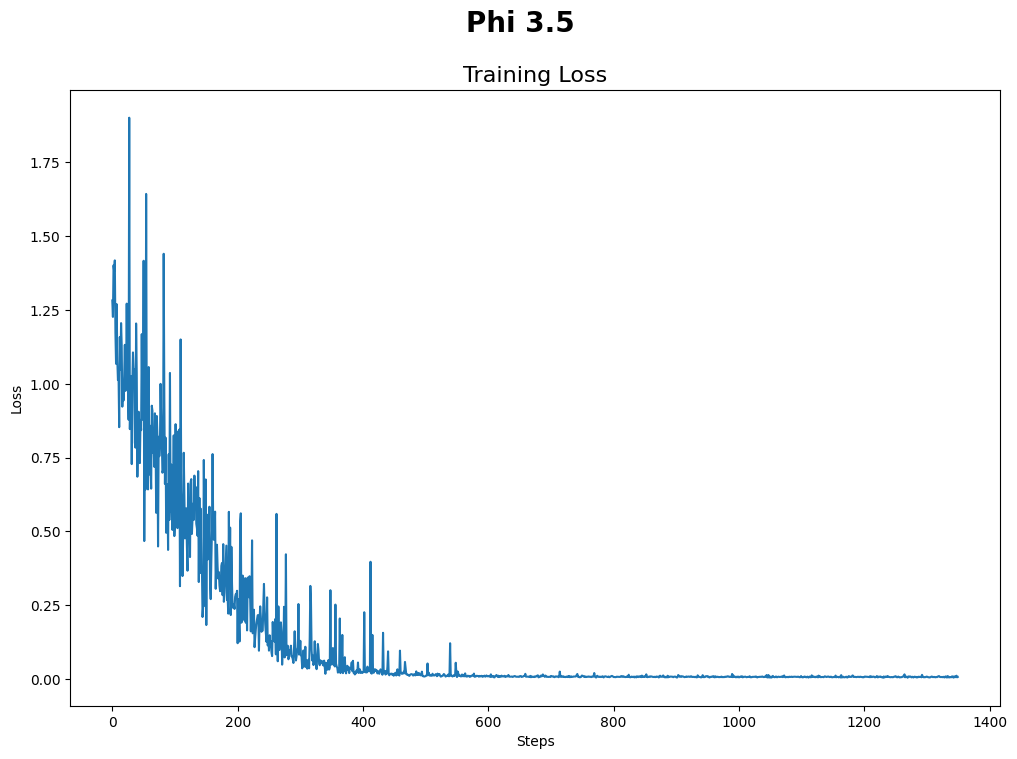

In [17]:
import matplotlib.pyplot as plt

# Extract the training losses from the log history
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

# Create the figure with larger size
plt.figure(figsize=(12, 8))  # Adjust the width and height (in inches)

# Plotting the loss curve
plt.plot(losses)

# Adding a heading for the figure
plt.suptitle("Phi 3.5", fontsize=20, fontweight='bold')

# Adding the title, axis labels, and displaying the plot
plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Loss", fontsize=10)

# Display the plot
plt.show()

In [13]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Dr. Nishat Afshan Ansari"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|user|> Dr. Nishat Afshan Ansari<|end|><|assistant|> {\n"name": "Dr. Nishat Afshan Ansari",\n"department": "Basic Science",\n"position": "Assistant Professor",\n"phone_no": "9754677390",\n"email": "nishat.ansari']

In [14]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Library details"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

{
"library": {
"description": "The Library at IIIT, Nagpur has a rich collection of over
133,000 books from various subjects such as Engineering, Basic Sciences, Behavioral Sciences,
Humanities, Media Sciences, Art, Environmental Studies, Management Studies,
Textile Technology, Economics, Statistics, Computer Science, Communication Skills,
Personality Development, Sports Studies, etc., lending the library a multidisciplinary
character.",
"collections": [
{
"subject": "Engineering": "More than 12


In [15]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

In [16]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Hostel Rules"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 1000, use_cache = True)

{
"rules": {
"general": {
"description": "The students of the Hostel shall obey all the rules framed for
the protection of rights and property of students as well as staff of the Institute. Students
shall abide by the rules framed by the Institute. The authority of the Hostel shall
function under the overall supervision of the Institute Dean Training & Placement (T&P)."),
"1": "Students shall pay rent details fees weterey money (including groceries,
electricity, water, etc.) spent during their stay in the Hostel.",
"2": "No student shall remain in the Hostel for more than 365 days in a
1"Norms for selection of students for stay in the Hostel":{
"1": "The authority may approve the selection of students for stay in the Hostel
on the recommendation of the Instructor-In-Charge or the Supervisor of the particular
batch, but where such recommendation is not available, the selection may be made by
the authority after testing the merit and financial status of the students.",
"2": "Students opt

In [22]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Board of governors"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 1000, use_cache = True)

{
"Board of Governors": {
"Chairperson": "Shri Ravi Sharma",
"Additional Charge": "Chairperson -BoG, IIIT, Una. HP",
"President": "IIT Alumni Council",
"Chairman": "Telecom Equipment Manufacturers Association of India (TEMA)",
"Founder": "Prama Jyoti Foundation / Mission Chetna / Subodhanand Foundation",
"Members": [
{
"Name": "Ms Saumya Gupta",
"Designation": "JS (Technical Education)",
"Organization": "MoE New Delhi"
},
{
"Name": "Dr Vinod Mohitkar",
"Designation": "Director",
"Organization": "DTE Govt. of Maharashtra, Mumbai"
},
{
"Name": "Shri Ajay R Bohora",
"Designation": "Co-Founder",
"Organization": "HDFC Credila Financial Services, Nashik"
},
{
"Name": "Dr (Mrs) B Padma S Rao",
"Designation": "Chief Scientist and Head Environmental Audit and PolicyImplementation Division",
"Organization": "CSIR-NEERI, Nagpur"
},
{
"Name": "Shri V Murlidharan",
"Designation": "Founder & Managing Trustee",
"Organization": "Sevalaya Chennai"
},
{
"Name": "Prof Dr Anupam Shukla",
"Designation": "D